# **Visualización y Detección de anomalías**
---

**Visualización:**
* Principal Component Analysis (50 componentes)
* TSNE (2 componentes)

**Detección de anomalías:**
* Isolation Forest (300 estimadores, 0.001 de contaminación)

### **1. Cargar datos**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar los arrays desde los archivos .npy
X_train = np.load('X_data.npy')
y_train = np.load('y_data.npy')

print("Imágenes y etiquetas cargadas desde archivos .npy")

Imágenes y etiquetas cargadas desde archivos .npy


---
## **2. Reducción de dimensionalidad**
---

In [3]:
# Seleccionar 20 clases aleatorias
np.random.seed(42)
unique_classes = np.unique(y_train)
selected_classes = np.random.choice(unique_classes, 20, replace=False)

In [4]:
# Filtrar los datos para las clases seleccionadas
selected_indices = np.isin(y_train, selected_classes)
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]

In [5]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Aplanar las imágenes para aplicar PCA/t-SNE
X_selected_flat = X_selected.reshape(X_selected.shape[0], -1)

# Aplicar PCA para reducción de dimensionalidad
pca = PCA(n_components=50)  # Primero reducir a 50 dimensiones para acelerar t-SNE
X_pca = pca.fit_transform(X_selected_flat)

# Aplicar t-SNE a los datos reducidos por PCA
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

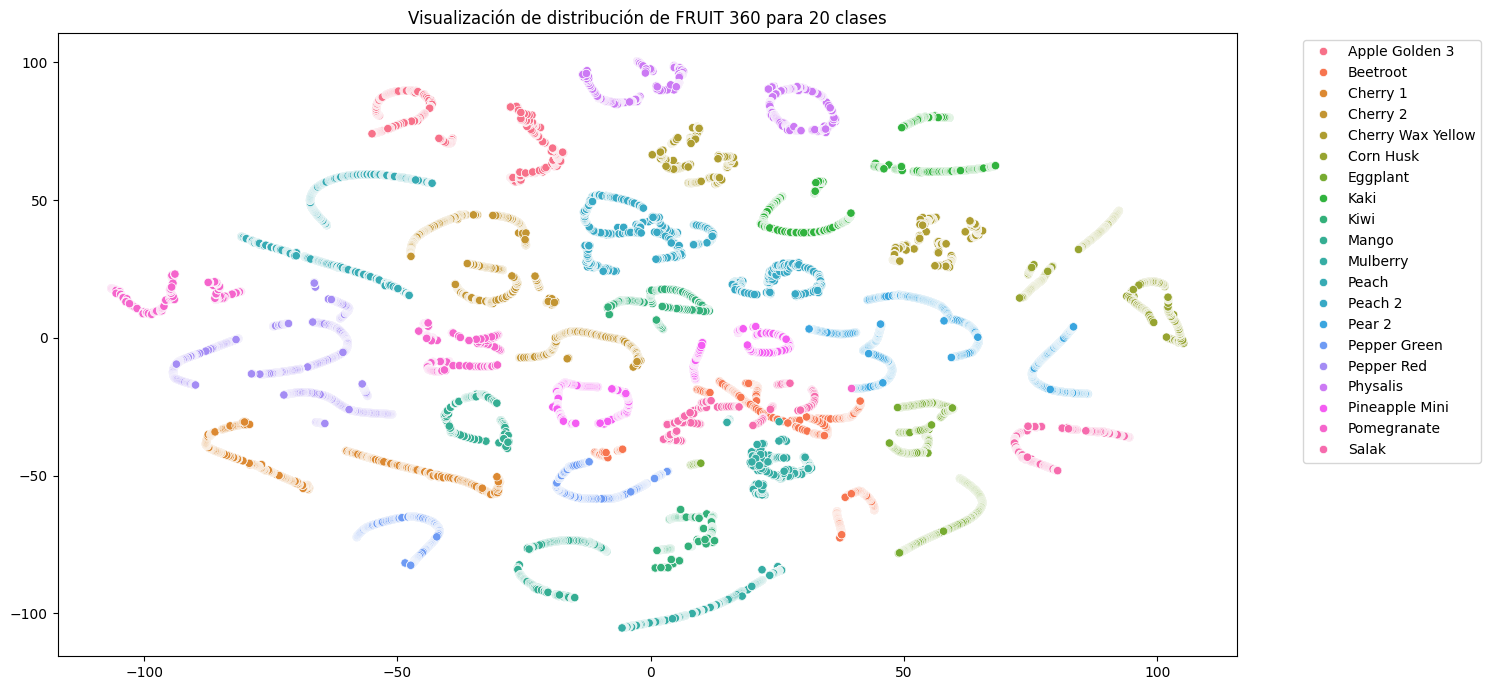

In [16]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x = X_tsne[:, 0], y = X_tsne[:, 1], hue=y_selected)
plt.title("Visualización de distribución de FRUIT 360 para 20 clases")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Se observa una clara distribución separada entre las clases, lo cual es un buen indicativo de que el dataset es suficientemente separable.

---
## **3. Detección de anomalías**
---

In [4]:
# Aplanar las imágenes para entrenar los modelos
X_train_flat = X_train.reshape(X_train.shape[0], -1)

In [ ]:
from sklearn.decomposition import PCA

# Reducir la dimensionalidad con PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train_flat)

In [4]:
# np.save('X_data_50d.npy', X_pca)
# Guardar datos para después empelarlos.

In [5]:
# Cargar datos
X_pca = np.load("X_data_50d.npy")

In [6]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Crear un DataFrame para almacenar las imágenes, sus etiquetas de outliers y las puntuaciones
df_outliers = pd.DataFrame({'label': y_train, 'image': list(X_train)})

# Listas para almacenar resultados por clase
outlier_scores_list = []
outlier_labels_list = []

# Detectar outliers por clase
for label in df_outliers['label'].unique():
    class_data = df_outliers[df_outliers['label'] == label].copy()
    X_class = X_pca[df_outliers['label'] == label]

    # Aplicar Isolation Forest para detección de outliers por clase
    isolation_forest = IsolationForest(n_estimators=200, contamination=0.001, random_state=42)
    isolation_forest.fit(X_class) 

    outlier_scores = isolation_forest.decision_function(X_class)
    outlier_labels = isolation_forest.predict(X_class)

    class_data['outlier'] = outlier_labels
    class_data['score'] = outlier_scores

    outlier_scores_list.append(class_data)

# Concatenar todos los DataFrames de resultados por clase
df_outliers = pd.concat(outlier_scores_list)

In [7]:
# Calcular el Z-score y luego escalar a [0, 1]
z_scores = zscore(df_outliers['score'])
min_z = z_scores.min()
max_z = z_scores.max()
df_outliers['score_normalized'] = (z_scores - min_z) / (max_z - min_z)
df_outliers["score_normalized"].describe()

count    67692.000000
mean         0.429092
std          0.162390
min          0.000000
25%          0.310479
50%          0.408689
75%          0.529703
max          1.000000
Name: score_normalized, dtype: float64

In [8]:
# El percentil sirva para darse una idea de los valores umbrales y en qué percentil se encuentran.
np.percentile(df_outliers["score_normalized"], 1)

0.1260082604716518

Cantidad de outliers por clase:
Apple Crimson Snow    1
Cantaloupe 1          1
Cherry Wax Black      1
Chestnut              1
Corn                  1
Nut Pecan             1
Pear Kaiser           1
Pepper Orange         1
Pineapple             1
Pitahaya Red          1
Pomegranate           1
Quince                1
Strawberry Wedge      1
Tomato Heart          1
Name: label, dtype: int64


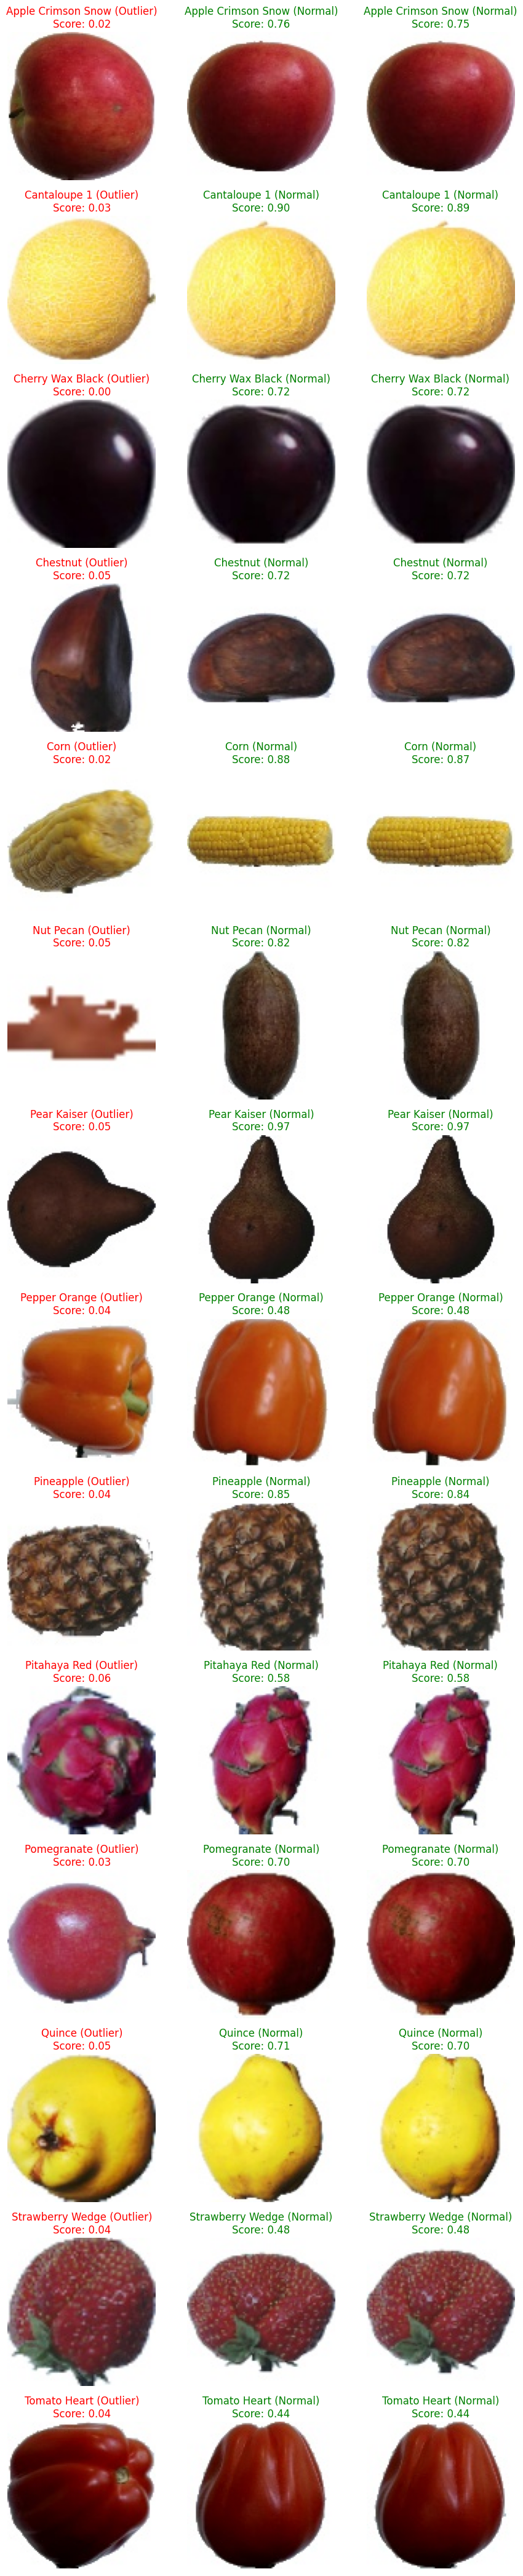

In [9]:
# Controlar el threshold
threshold = 0.06
df_outliers_filtered = df_outliers[df_outliers['score_normalized'] <= threshold]

# Filtrar solo las muestras normales
df_normals = df_outliers.copy()
df_normals = df_normals.groupby('label').apply(lambda x: x.nlargest(2, 'score_normalized')).reset_index(drop=True)

# Mostrar la cantidad de outliers por clase y seleccionar las 30 clases con más outliers
outliers_count = df_outliers_filtered['label'].value_counts().head(30)
print("Cantidad de outliers por clase:")
print(outliers_count)

# Número de valores a mostrar
n_outliers = 1
n_normals = 2

# Crear subplots
fig, axes = plt.subplots(len(outliers_count), n_outliers + n_normals, figsize=((n_outliers + n_normals) * 3, len(outliers_count) * 3))

for i, (label, count) in enumerate(outliers_count.items()):
    # Obtener las imágenes de los outliers con menor puntuación (más anómalas)
    top_outliers = df_outliers_filtered[df_outliers_filtered['label'] == label].nsmallest(n_outliers, 'score_normalized')  # nsmallest para los más negativos
    
    # Obtener las imágenes de los valores normales con mayor puntuación (más normales)
    top_normals = df_normals[df_normals['label'] == label].nlargest(n_normals, 'score_normalized')  # nlargest para los más positivos

    # Mostrar outliers
    for j, (_, row) in enumerate(top_outliers.iterrows()):
        axes[i, j].imshow(row['image'])
        axes[i, j].set_title(f"{label} (Outlier)\nScore: {row['score_normalized']:.2f}", color='red')
        axes[i, j].axis('off')

    # Mostrar valores normales
    for j, (_, row) in enumerate(top_normals.iterrows()):
        axes[i, j + n_outliers].imshow(row['image'])
        axes[i, j + n_outliers].set_title(f"{label} (Normal)\nScore: {row['score_normalized']:.2f}", color='green')
        axes[i, j + n_outliers].axis('off')

plt.tight_layout()
plt.show()

Al parecer solamente Nut Pecan posee un outlier. Las demás clases se observan normales.

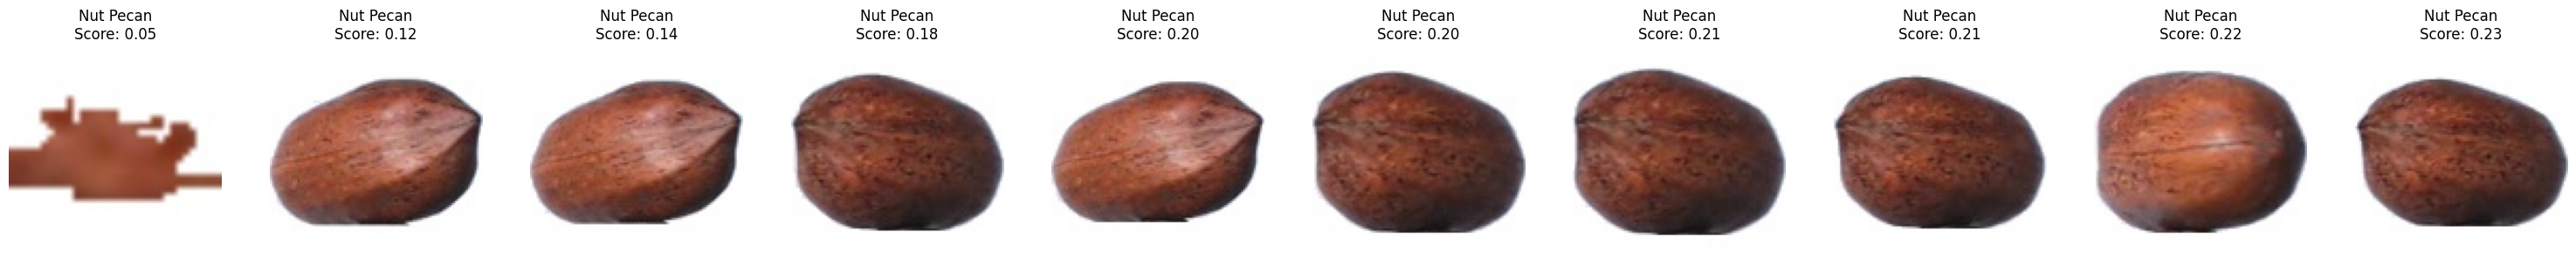

In [10]:
# Controlar el threshold
threshold = 0.3
df_outliers_filtered = df_outliers[df_outliers['score_normalized'] <= threshold]

# Filtrar los outliers de la clase "Nut Pecan"
class_label = "Nut Pecan"
df_nut_pecan_outliers = df_outliers_filtered[df_outliers_filtered['label'] == class_label]

# Seleccionar varios outliers con score menor al threshold
selected_outliers = df_nut_pecan_outliers.nsmallest(10, 'score_normalized') 

# Visualizar los outliers seleccionados
fig, axes = plt.subplots(1, len(selected_outliers), figsize=(len(selected_outliers) * 3, 3))

for i, (_, row) in enumerate(selected_outliers.iterrows()):
    axes[i].imshow(row['image'])
    axes[i].set_title(f"{class_label}\nScore: {row['score_normalized']:.2f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

---
### Eliminar muestra

Int64Index([37131], dtype='int64')
El outlier 'Nut Pecan' con score 0.005 ha sido eliminado.


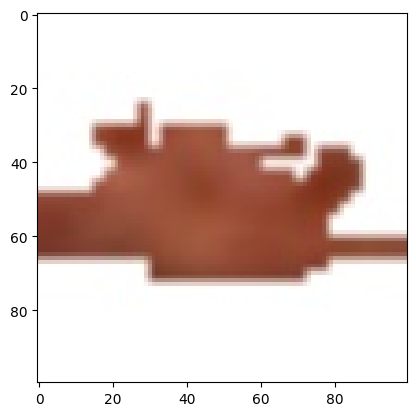

In [11]:
# Filtrar los outliers de la clase "Nut Pecan"
class_label = "Nut Pecan"
pecan_outlier_score = 0.001  # El score específico a eliminar
df_nut_pecan_outliers = df_outliers_filtered[df_outliers_filtered['label'] == class_label]

# Identificar la posición del outlier específico
outlier_index = df_nut_pecan_outliers[df_nut_pecan_outliers['score'] < pecan_outlier_score].index

print(outlier_index)

plt.imshow(X_train[outlier_index[0]])

# Eliminar la muestra correspondiente de X_pca y y_train
X_train_cleaned = np.delete(X_train, outlier_index, axis=0)
y_train_cleaned = np.delete(y_train, outlier_index, axis=0)

# Confirmar que el outlier ha sido eliminado
print(f"El outlier 'Nut Pecan' con score 0.005 ha sido eliminado.")

In [14]:
X_train_cleaned.shape, y_train_cleaned.shape

((67691, 100, 100, 3), (67691,))

In [15]:
np.save("X_data_cleaned.npy", X_train_cleaned)
np.save("y_data_cleaned.npy", y_train_cleaned)
print("Archivos Guardados.")

Archivos Guardados.
